In [1]:
import kmodels as kmk
from kmodels import models as models
import torch 
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn import functional as F
# get ModuleList from torch.nn
from torch.nn import ModuleList
# create a cv function
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# get base form sklearn
from sklearn.base import BaseEstimator, RegressorMixin

# train the VAE
from torch.functional import F
from torch import optim
from sklearn.linear_model import LinearRegression
import time
import torch
from torch.utils.data import TensorDataset, DataLoader
import time

# lets get the MultiLRstep from torch to schedule the learning rate
from torch.optim.lr_scheduler import MultiStepLR
from kmodels import models as models

In [3]:
n = 10000
n_features = 10
binary_dim = 0
float_dim = n_features - binary_dim
x_bin = np.random.randint(2, size=(n, binary_dim))
x_float = np.random.rand(n, float_dim)
x = np.concatenate((x_bin, x_float), axis=1)
y = np.sin(x[:,0]) + np.cos(x[:,1])
# # y will be piecewise linear function of x using binary dim as a switch
# y = np.zeros(n)
# for i in range(n):
#     if x_bin[i] == 0:
#         y[i] = np.sum(x_float[i])
#     else:
#         y[i] = np.sum(x_float[i]**2)
x.shape, y.shape, x, x_bin

((10000, 10),
 (10000,),
 array([[0.3703444 , 0.03194497, 0.04464446, ..., 0.20839104, 0.2835608 ,
         0.32722404],
        [0.73846014, 0.18894549, 0.76739661, ..., 0.83527527, 0.80291933,
         0.82074393],
        [0.27996948, 0.52045817, 0.11650488, ..., 0.38314375, 0.29490867,
         0.09857218],
        ...,
        [0.68193509, 0.08467402, 0.45061293, ..., 0.64570699, 0.16630204,
         0.06613507],
        [0.39494365, 0.53887475, 0.47796942, ..., 0.56776654, 0.84674933,
         0.9523617 ],
        [0.64870357, 0.82101942, 0.36711494, ..., 0.29654563, 0.66901858,
         0.06509903]]),
 array([], shape=(10000, 0), dtype=int32))

In [4]:
def scale_data(x, binary_dim=0):
    if binary_dim>0:
        bin_scaler = MinMaxScaler()
        float_scaler = StandardScaler()
        x_bin = bin_scaler.fit_transform(x[:, :binary_dim])
        x_float = float_scaler.fit_transform(x[:, binary_dim:])
        print('binary scaler: ', x_bin.shape)
        print('float scaler: ', x_float.shape)
        x = np.concatenate((x_bin, x_float), axis=1)
    else:
        bin_scaler = None
        float_scaler = StandardScaler()
        x = float_scaler.fit_transform(x)
        print('float scaler: ', x.shape)
    return x, bin_scaler, float_scaler

x, bin_scaler, float_scaler = scale_data(x, binary_dim=binary_dim)
x.shape

float scaler:  (10000, 10)


(10000, 10)

In [5]:
from torch.utils.data import TensorDataset
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
dataset = TensorDataset(x, y)



In [6]:
from sklearn.model_selection import GridSearchCV
param_dist = {'fc_layers':[3, 5], 'lr_init':[0.01, 0.001], 'kernel_size':[3, 5]}
reg = kmk.Trainer(**{'conv_layers':1, 'estimator_type':'CNN', 'batch_size':1000, 'fc_size':10,
                     'epochs':101, 'fc_size':10, 'verbose':10,'reg_factor':0})
grid_ = GridSearchCV(reg, param_dist, cv=2, verbose=1, n_jobs=1)

CNN
{'conv_layers': 1, 'batch_size': 1000, 'fc_size': 10, 'epochs': 101, 'verbose': 10, 'reg_factor': 0}


In [18]:
#reg = grid_.best_estimator_
reg = kmk.Trainer(**{ 'verbose':5,
                 'estimator_type':'NN', 
                 'layers':3, 
                 'layer_size':10, 
                 'batch_size':100,
                 'lr_init':0.001,
                 'device':'cuda',
})
reg.config

NN
{'verbose': 5, 'layers': 3, 'layer_size': 10, 'batch_size': 100, 'lr_init': 0.001, 'device': 'cuda'}


{'verbose': 5,
 'layers': 3,
 'layer_size': 10,
 'batch_size': 100,
 'lr_init': 0.001,
 'device': 'cuda',
 'epochs': 100,
 'metric': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', force_finite=True)>,
 'lr_gamma': 0.1,
 'scheduler': kmodels.utils.LR_scheduler,
 'is_VAE': False,
 'n_inputs': 106,
 'n_outputs': 1,
 'binary_dim': 0,
 'reg_factor': 0.0,
 'beta': 0,
 'gamma': 0,
 'binary_dim_y': 0,
 'estimator_type': 'NN',
 'change_layers': 0}

In [19]:
print(x.shape, y.shape)
x = x.to('cuda')
y = y.to('cuda')
reg.fit(x,y.reshape(-1,1))


torch.Size([10000, 10]) torch.Size([10000, 1])
====> Epoch: 0 Average loss: 0.437539279 Time: 1.07
Loss components: {}
====> Epoch: 5 Average loss: 0.010765175 Time: 0.89
Loss components: {}
====> Epoch: 10 Average loss: 0.005681703 Time: 0.90
Loss components: {}
====> Epoch: 15 Average loss: 0.003121934 Time: 0.90
Loss components: {}
====> Epoch: 20 Average loss: 0.001711660 Time: 0.99
Loss components: {}
====> Epoch: 25 Average loss: 0.000586464 Time: 1.03
Loss components: {}
====> Epoch: 30 Average loss: 0.000260650 Time: 1.01
Loss components: {}
====> Epoch: 35 Average loss: 0.000263040 Time: 0.91
Loss components: {}
====> Epoch: 40 Average loss: 0.000128131 Time: 0.91
Loss components: {}
====> Epoch: 45 Average loss: 0.000127930 Time: 0.90
Loss components: {}
====> Epoch: 50 Average loss: 0.000094063 Time: 0.95
Loss components: {}
====> Epoch: 55 Average loss: 0.000086814 Time: 1.02
Loss components: {}


KeyboardInterrupt: 

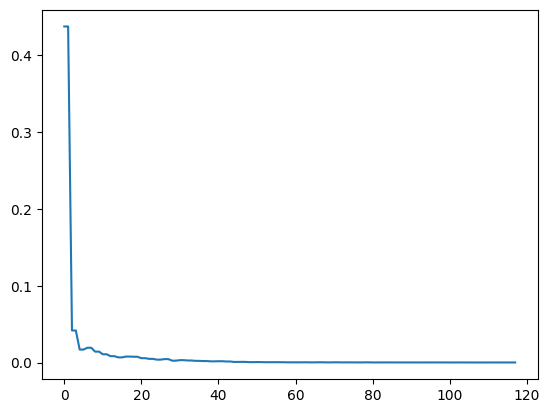

In [21]:
plt.plot(reg.losses.detach().cpu())

In [10]:
reg.train()

====> Epoch: 0 Average loss: 0.001248052 Time: 0.95
Loss components: {}
====> Epoch: 5 Average loss: 0.000228206 Time: 1.00
Loss components: {}
====> Epoch: 10 Average loss: 0.000065748 Time: 1.03
Loss components: {}
====> Epoch: 15 Average loss: 0.000054215 Time: 1.02
Loss components: {}
====> Epoch: 20 Average loss: 0.000035690 Time: 1.00
Loss components: {}


In [22]:
reg.score(x,y.reshape(-1,1)), [i for i in reg.estimator.modules()]

(0.998820919619833,
 [NN(layer_size=10, n_inputs=10),
  Linear(in_features=10, out_features=10, bias=True),
  ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  ),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=10, bias=True),
  Linear(in_features=10, out_features=1, bias=True)])

In [15]:
reg.estimator_params

{'estimator_type': 'NN',
 'n_inputs': 106,
 'n_outputs': 1,
 'layers': 3,
 'layer_size': 10,
 'change_layers': 0}

In [23]:
# plot the results of the grid search
import pandas as pd
df = pd.DataFrame(grid_.cv_results_)
# make a contour plot where color is the score and x and y are the parameters (lr_init and fc_layers)
fig = px.scatter_3d(df, x='param_lr_init', y='param_fc_layers', z='mean_test_score', color='mean_test_score')
fig.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

tensor([[1.3771],
        [1.6388],
        [1.1531],
        ...,
        [1.6295],
        [1.2496],
        [1.2759]])
torch.Size([10000, 1]) torch.Size([10000, 1])


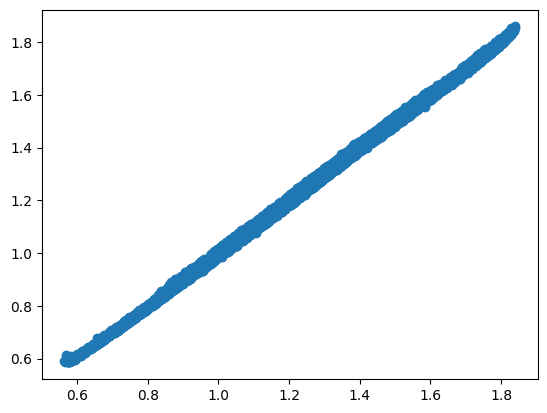

In [24]:
#plt.plot(reg.losses)
pred = reg.predict(x).reshape(-1, 1)
print(pred)
print(pred.shape, y.shape)
plt.scatter(y.reshape(-1, 1).detach().cpu(), pred)

In [25]:
# best_model = reg
# #plt.plot(best_model.losses)
# print(grid_.best_params_)
# print(grid_.best_score_)
best_model = reg
pred = best_model.predict(x).reshape(-1,1)
plt.plot(pred.detach().numpy(), y.detach().numpy().reshape(-1,1), 'o')

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
trainer = kmk.trainer(**{'binary_dim':0, 'binary_dim_y':0, 'model_type':'NN', 'epochs':11,'lr_init':1e-3,
                       'batch_size':1000,'beta':0, 'gamma':0, 'layers':5, 'layer_size':100})
trainer.fit(x.reshape(-1, 1), y.reshape(-1, 1))

AttributeError: module 'kmodels' has no attribute 'trainer'

In [ ]:
plt.plot(trainer.losses)

In [ ]:
pred = trainer.predict(x.reshape(-1,1)).reshape(-1,1)
plt.scatter(pred, y)

In [ ]:
x

In [ ]:
new_model = kmk.NN(n_inputs=x.shape[1], n_outputs=y.shape[1], layers=2, layer_size=50)
reg = kmk.trainer({'n_inputs':x.shape[1], 'n_outputs':y.shape[1], 'layers':2, 'layer_size':50})
params = reg.params
reg.set_params(**params)

In [ ]:
from ray import tune
import ray
import os

def train_model(config: dict):
    trainer = kmk.Trainer({'binary_dim':0, 'binary_dim_y':0, 'model_type':'NN', 'epochs':11,'lr_init':1e-3,
                           'batch_size':1000,'beta':0, 'gamma':0, 'layers':5, 'layer_size':100})
    trainer.set_params(**config)
    trainer.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    return trainer


In [ ]:
from ray.train.torch import TorchTrainer
from ray.air import ScalingConfig
# get the logging
ray.init(num_cpus=1, log_to_driver=False)
# For GPU Training, set `use_gpu` to True.
# trainer = Trainer(backend="torch", num_workers=2, use_gpu=True)
scaling_config = ScalingConfig(train_model, num_workers=1)
config = {}
trainer = TorchTrainer(train_loop_per_worker=train_model, train_loop_config=config)
trainer.fit()

In [ ]:
import ray

# Connect to the Ray cluster.
ray.init()

# Define a remote function to check the status of a worker.
@ray.remote
def check_worker_status(worker_id):
    # Add your logic here to check the worker's status.
    # For example:
    # return True if the worker is healthy, otherwise False.
    return True

# Get a list of all workers in the cluster.
all_workers = ray.nodes()

# Check the status of each worker in parallel.
worker_statuses = ray.get([check_worker_status.remote(worker["NodeID"]) for worker in all_workers])

# Print the status of each worker.
for worker, status in zip(all_workers, worker_statuses):
    print(f"Worker {worker['NodeID']} is {'healthy' if status else 'unhealthy'}.")


In [ ]:
trainer = train_model({'epochs':51})
plt.plot(trainer.losses)


In [ ]:
pred = trainer.predict(trainer.x).reshape(-1,1)
plt.scatter(pred, trainer.y)

In [ ]:
model = kmk.NN(n_inputs=x.shape[1], n_outputs=y.shape[1], layers=2, layer_size=50, change_layers=0)
model

In [ ]:
tlnn = kmk.TLNN(model, x, change_layers=1)
tlnn

In [ ]:
model.__init__(**model.params)